# Datathon Cajamar PythonHack 2016
Team: WoodenSpoonNinjas

We start by importing the packages/modules we are using below:

In [20]:
from collections import Counter
import numpy as np
import pandas as pd
import seaborn

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.metrics import roc_curve, roc_auc_score, precision_recall_curve, confusion_matrix, classification_report
from sklearn import metrics   # more metrics

from sklearn.model_selection import GridSearchCV  # cross-validation via grid search

import xgboost as xgb
from xgboost.sklearn import XGBClassifier
  
import itertools

First we load the training dataset as a Pandas DataFrame and split variables into dependent and independent variables, `X` and `y`, respectively. Then, we count the number of samples in each class:

In [2]:
filename = 'pm_train.txt'
D = pd.read_csv(filename, delimiter="|", decimal=",", index_col=0)
D = D.reindex_axis(sorted(D.columns), axis=1)
columns = D.columns

X = D.drop(["TARGET"],axis=1).values
y = D["TARGET"].values

print("Summary: {} samples x {} features".format(*X.shape))
c = Counter(y)
print("Number of target values for each class: 0: {}, 1: {}".format(c[0],c[1]))

Summary: 471838 samples x 97 features
Number of target values for each class: 0: 464360, 1: 7478


It can be seen that classes are highly imbalanced (only 1.6 % belong to class 1). At this point, we have 2 choices: 
1. Balance the number of samples in both classes: using undersampling, oversampling or a combination of them.
2. Do not balance the number of samples in each class and force our model to take into account the *a priori* probability of each class in its predictions.

The evaluation criteria for the challenge indicate that correctly classifying both classes will be taken into account (both specificity and sensivity will be evaluated). Consequently, we will follow approach 1, thus avoiding that our results are biased towards class 0 due to class imbalance. This way, we also obtain a model which is robust against future changes in the *a priori* probability of clients asking/not asking for a loan.

In [3]:
method = "US"
if method == "US":
    from imblearn.under_sampling import RandomUnderSampler
    resamp = RandomUnderSampler(random_state=42)
    X_res, y_res = resamp.fit_sample(X, y)
elif  method == "OS":
    from imblearn.over_sampling import SMOTE
    resamp = SMOTE(random_state=42)
    X_res, y_res = resamp.fit_sample(X, y)
    sel = np.random.randint(0, y_res.shape[0], 20000)
    X_res = X_res[sel,:]
    y_res = y_res[sel]   
else:
    X_res, y_res = X, y

c = Counter(y_res)
print("Number of target values for each class after resampling: 0: {}, 1: {}".format(c[0],c[1]))

Number of target values for each class after resampling: 0: 7478, 1: 7478


In [4]:
X_sel = X_res  # select all features for all resampled rows

## Cross validation
As classification model we have chosen a *eXtreme Gradient Boosting* classifier from the `xgboost` library. Given the large number of hyper-parameters in this type of models, we will perform a sequential cross-validation. This approach is justified by the fact that we are under tight time (and computacional) constraints and an exhaustive grid search cross-validation will be intractable.

### Hyperparameter selection (step 1): number of estimators
First, we fix every model parameter but the number of estimators and carry out a cross-validation step to obtain the optimal number of estimators. In order to do so, we implement the helper function `modelfit`:

In [5]:
def modelfit(alg, predictors, target, useTrainCV=True, cv_folds=5, early_stopping_rounds=50):
    if useTrainCV:
        xgb_param = alg.get_xgb_params()
        xgtrain = xgb.DMatrix(predictors, label=target)
        cvresult = xgb.cv(xgb_param, xgtrain, num_boost_round=xgb_param['n_estimators'], nfold=cv_folds,
                          metrics='auc', early_stopping_rounds=early_stopping_rounds, verbose_eval=True)
        alg.set_params(n_estimators=cvresult.shape[0])

        
    # Fit the algorithm on the data
    alg.fit(predictors, target, eval_metric='auc')

    # Predict training set:
    dtrain_predictions = alg.predict(predictors)
    dtrain_predprob = alg.predict_proba(predictors)[:, 1]

    # Print model report:
    print("Model Report")
    print("Accuracy : %.4g" % metrics.accuracy_score(target, dtrain_predictions))
    print("AUC Score (Train): %f" % metrics.roc_auc_score(target, dtrain_predprob))
    

    feat_imp = pd.Series(alg.booster().get_fscore()).sort_values(ascending=False).iloc[:20]
    plt.figure(figsize=(20,10))
    feat_imp.plot(kind='bar', title='Feature Importances')
    plt.ylabel('Feature Importance Score')
    matplotlib.rcParams.update({'font.size': 22})
    return alg

In [6]:
# Define some defaults for plotting
def init_plotting():
    plt.rcParams['figure.figsize'] = (8, 3)
    plt.rcParams['font.size'] = 16
    #plt.rcParams['font.family'] = 'Times New Roman'
    plt.rcParams['axes.labelsize'] = plt.rcParams['font.size']
    plt.rcParams['axes.titlesize'] = 1.5*plt.rcParams['font.size']
    plt.rcParams['legend.fontsize'] = plt.rcParams['font.size']
    plt.rcParams['xtick.labelsize'] = plt.rcParams['font.size']
    plt.rcParams['ytick.labelsize'] = plt.rcParams['font.size']
    plt.rcParams['savefig.dpi'] = 200
    plt.rcParams['xtick.major.size'] = 3
    plt.rcParams['xtick.minor.size'] = 3
    plt.rcParams['xtick.major.width'] = 1
    plt.rcParams['xtick.minor.width'] = 1
    plt.rcParams['ytick.major.size'] = 3
    plt.rcParams['ytick.minor.size'] = 3
    plt.rcParams['ytick.major.width'] = 1
    plt.rcParams['ytick.minor.width'] = 1
    plt.rcParams['legend.frameon'] = False
    plt.rcParams['legend.loc'] = 'center left'
    plt.rcParams['axes.linewidth'] = 1

init_plotting()

[0]	train-auc:0.839808+0.00171059	test-auc:0.826817+0.0103184
[1]	train-auc:0.851201+0.00392178	test-auc:0.837704+0.00693683
[2]	train-auc:0.858353+0.00328648	test-auc:0.84396+0.0079885
[3]	train-auc:0.86212+0.00330253	test-auc:0.847497+0.00756405
[4]	train-auc:0.865265+0.00278012	test-auc:0.85011+0.00799946
[5]	train-auc:0.867921+0.00302978	test-auc:0.852881+0.00793075
[6]	train-auc:0.86987+0.00339854	test-auc:0.854506+0.00822721
[7]	train-auc:0.872393+0.00287162	test-auc:0.856482+0.00791109
[8]	train-auc:0.874293+0.00311432	test-auc:0.858005+0.00736747
[9]	train-auc:0.876129+0.00277235	test-auc:0.859624+0.007468
[10]	train-auc:0.877636+0.00269972	test-auc:0.860497+0.00767365
[11]	train-auc:0.879046+0.00246435	test-auc:0.861499+0.0079584
[12]	train-auc:0.880173+0.00245154	test-auc:0.862691+0.00771334
[13]	train-auc:0.881602+0.00205924	test-auc:0.86382+0.00788325
[14]	train-auc:0.882786+0.00191871	test-auc:0.864604+0.00805297
[15]	train-auc:0.884163+0.00179159	test-auc:0.865775+0.00806

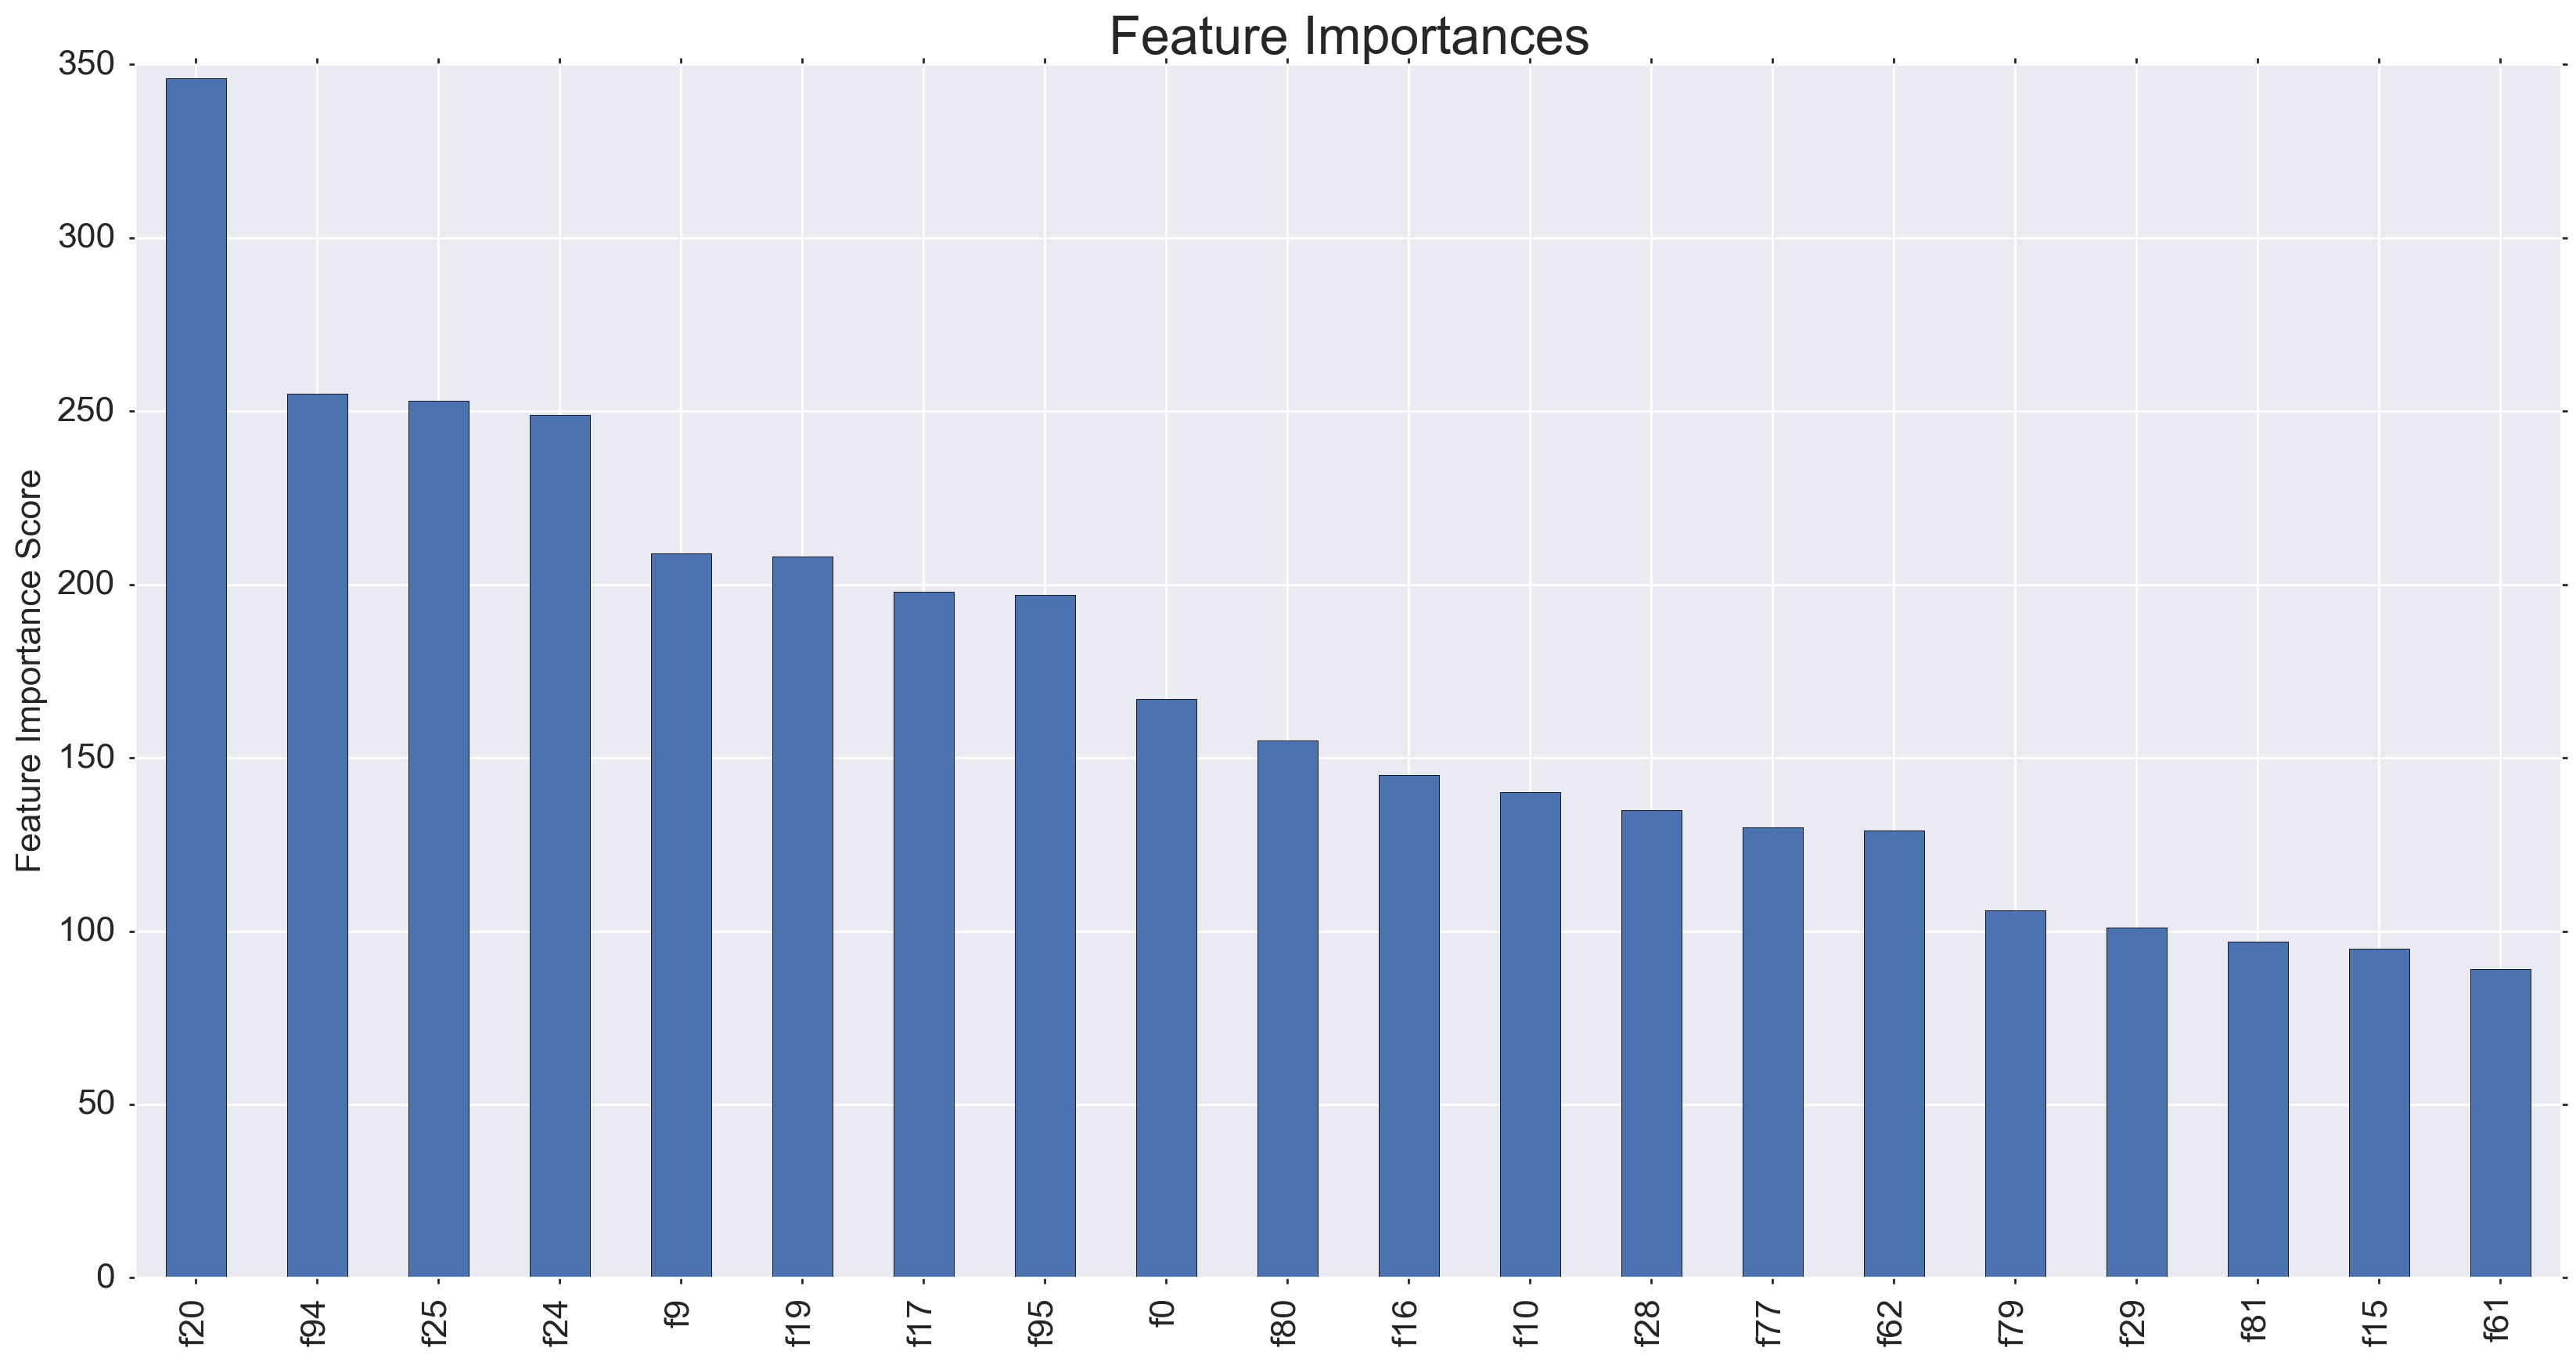

In [7]:
xgb1 = XGBClassifier(
                     learning_rate=0.1,
                     n_estimators= 1000,
                     max_depth=5,
                     min_child_weight=1,
                     gamma=0,
                     subsample=0.8,
                     colsample_bytree=0.8,
                     objective= 'binary:logistic',
                     nthread=-1,
                     scale_pos_weight=c[0]/c[1],  #neg/pos classes
                     seed=27,
                     silent=1)

alg = modelfit(xgb1, X_sel, y_res)

In [8]:
# Saved the trained model
#from sklearn.externals import joblib
#joblib.dump(alg,'imbalanced_alg.pkl')
#joblib.dump(alg,'balanced_undersampled_alg.pkl')
#alg = joblib.load('imbalanced_alg.pkl')
#alg = joblib.load('balanced_undersampled_alg.pkl')

### Hyperparameter selection (step 2): `max_depth` & `min_child_weight`
The sweep above ends up giving us the optimal number of estimators (at least, for our particular choice of the rest of parameters). In the following code, we fix the number of estimators and cross-validate for the parameters `max_depth` and `min_child_weight`:

In [9]:
param_test1 = {
 'max_depth': range(3,10,2),
 'min_child_weight': range(1,6,2)
}
gsearch1 = GridSearchCV(estimator=XGBClassifier(**alg.get_xgb_params()),
param_grid = param_test1, scoring='roc_auc', n_jobs=-1, iid=False, cv=5, verbose=10)
gsearch1.fit(X_sel, y_res)
print(gsearch1.best_params_)
print(gsearch1.best_score_)

[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:  2.7min
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:  4.0min
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  5.8min
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  8.2min
[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed: 12.0min
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed: 13.7min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed: 13.7min finished


Fitting 5 folds for each of 12 candidates, totalling 60 fits
{'max_depth': 5, 'min_child_weight': 1}
0.894082296817


### Hyperparameter selection (step 3): `gamma`
Now, assuming `n_estimators`, `max_depth` and `min_child_weight` are fixed, we cross-validate for `gamma`:

In [10]:
param_test2 = {
 'gamma':[i/10.0 for i in range(0,10)]
}
gsearch2 = GridSearchCV(estimator=gsearch1.best_estimator_,
 param_grid = param_test2, scoring='roc_auc', n_jobs=-1, iid=False, cv=5, verbose=10)
gsearch2.fit(X_sel, y_res)
print(gsearch2.best_params_)
print(gsearch2.best_score_)

[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:  3.9min
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:  5.4min
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  7.1min
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  9.0min
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed: 10.4min finished


Fitting 5 folds for each of 10 candidates, totalling 50 fits
{'gamma': 0.9}
0.894590371046


### Choosing the rest of hyperparameters
You can keep cross-validating for the rest of hyperparameters. For the sake of conciseness, details are omitted and only final results are shown here.

## Final model
Once all cross-validation steps are carried out, we end up with the following model:

In [15]:
alg = gsearch2.best_estimator_
alg.get_params()

{'base_score': 0.5,
 'colsample_bylevel': 1,
 'colsample_bytree': 0.8,
 'gamma': 0.9,
 'learning_rate': 0.1,
 'max_delta_step': 0,
 'max_depth': 5,
 'min_child_weight': 1,
 'missing': None,
 'n_estimators': 242,
 'nthread': -1,
 'objective': 'binary:logistic',
 'reg_alpha': 0,
 'reg_lambda': 1,
 'scale_pos_weight': 1.0,
 'seed': 27,
 'silent': 1,
 'subsample': 0.8}

For a final check, we split our dataset into test and train datasets and perform a last cross-validation before applying our model to true test dataset. The goal of this is doubling checking that there is no significant overfitting and our predictions are not biased due to class imbalance.

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X_sel, y_res, test_size=0.4, random_state=0, stratify=y_res)
alg = alg.fit(X_train, y_train)
y_pred = alg.predict(X_test)
pred_prob = alg.predict_proba(X_test)[:, 1]
fpr, tpr, _ = roc_curve(y_test, pred_prob)

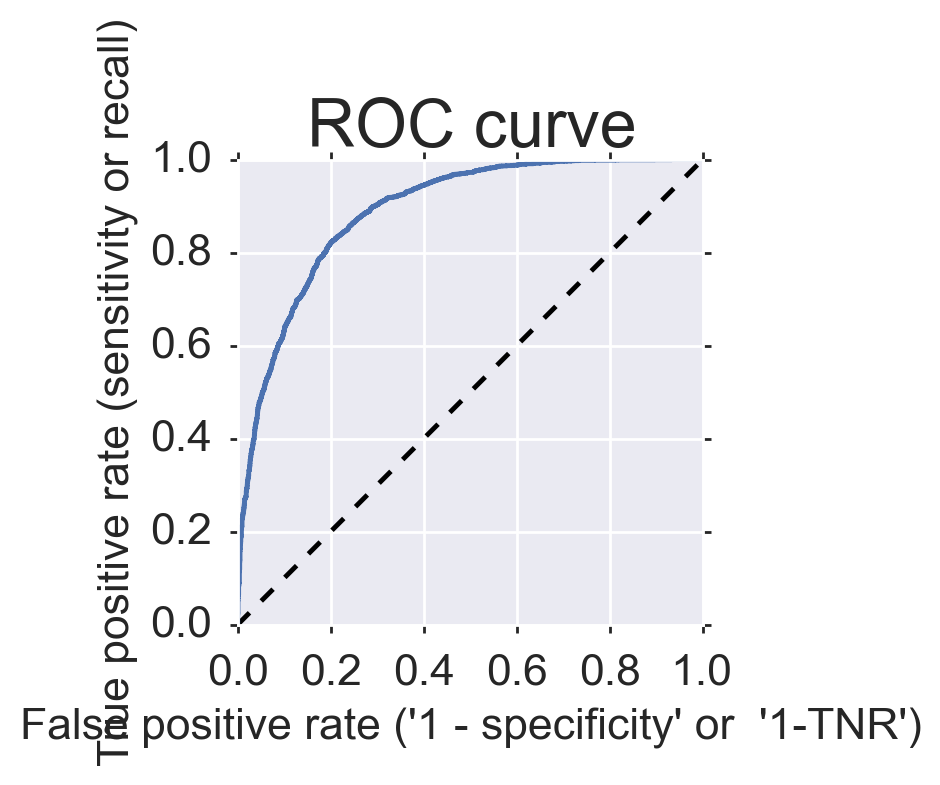

ROC-AUC = 0.8895977705844806


In [13]:
plt.figure(figsize=(3,3))
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr, label='xgBoost')
plt.xlabel("False positive rate ('1 - specificity' or  '1-TNR')")
plt.ylabel('True positive rate (sensitivity or recall)')
plt.title('ROC curve')
#plt.legend(loc='best')
plt.show()
auc = roc_auc_score(y_test, pred_prob)
print("ROC-AUC = {}".format(auc))
# alg.score(X_test, y_test)

Confusion matrix, without normalization
[[2337  655]
 [ 490 2501]]
Normalized confusion matrix
[[ 0.78  0.22]
 [ 0.16  0.84]]


C:\Anaconda3\lib\site-packages\matplotlib\collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


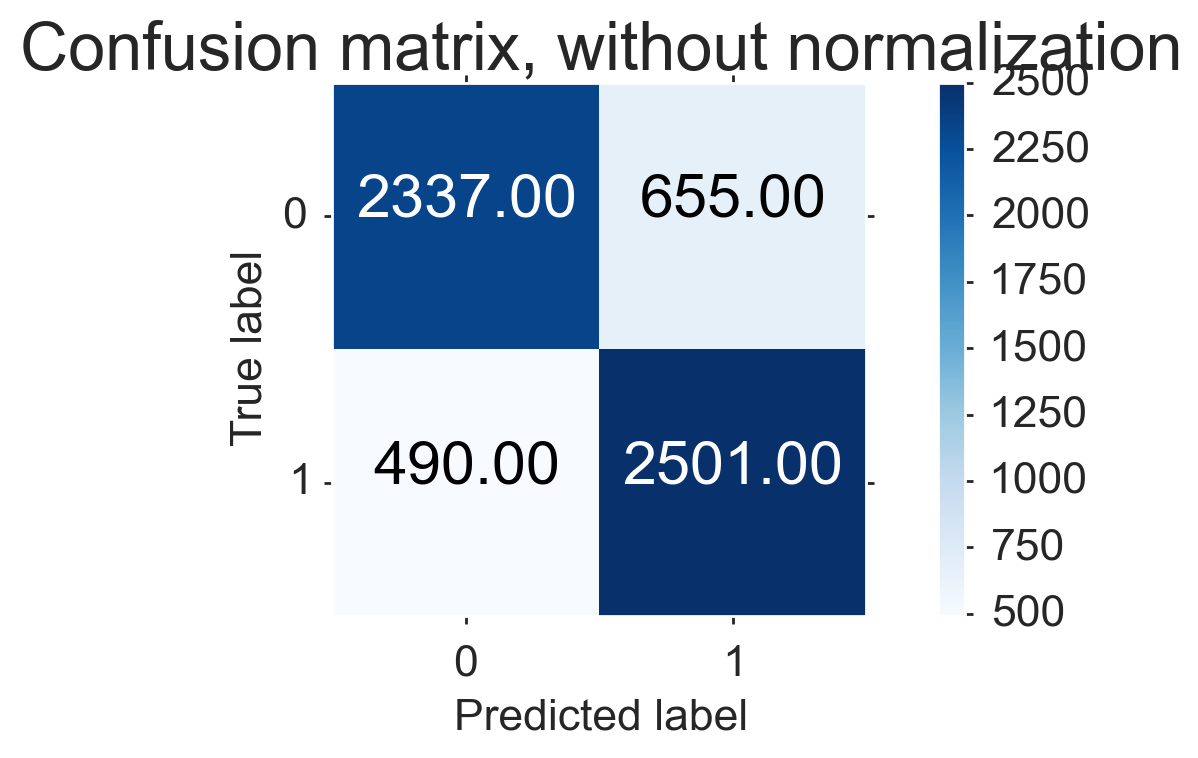

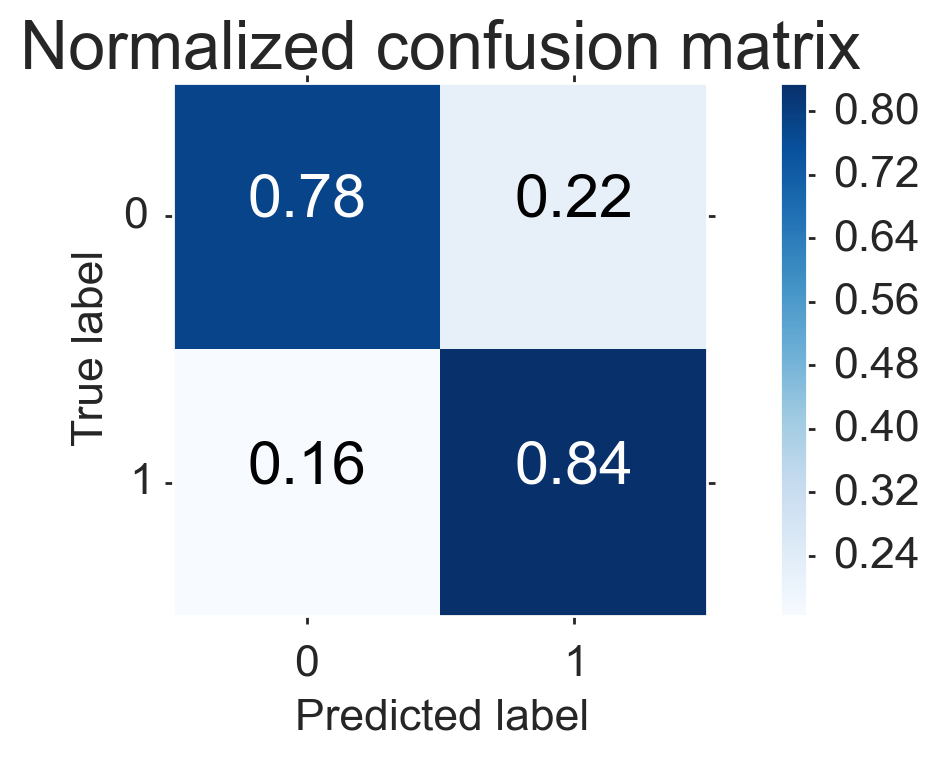

In [19]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    
    if normalize:
        cm = cm/cm.sum(axis=1, keepdims=True)
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, "%.2f" % cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.grid(False)
    plt.colorbar()    
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    return cm

class_names = ["0", "1"]    
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure(figsize=(8,4))
a = plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')

print('Confusion matrix, without normalization')
print(a)

# Plot normalized confusion matrix
plt.figure(figsize=(8,4))
b = plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

print("Normalized confusion matrix")
print(b)

plt.show()

## Prediction in the test dataset
Load test dataset and perform prediction step:

In [17]:
filename = 'pm_test.txt'  # read test data file
D = pd.read_csv(filename, delimiter="|", decimal=",", index_col = 0)
D = D.reindex_axis(sorted(D.columns), axis=1) # sort columns by name

In [18]:
# Predict target values for the test dataset
X_test_final = D.values
y_pred_final = alg.predict(X_test_final)
c = Counter(y_pred_final)  # count the number of sample in each class
print("Number of target values for each predicted class: 0: {}, 1: {}".format(c[0],c[1]))

Number of target values for each predicted class: 0: 155090, 1: 47427


## Saving predicted values to the submission file

In [ ]:
D_resp = pd.Series(y_pred_final, index = D.index, name="Respuesta").to_frame()
D_resp.to_csv("submission.txt", sep="|")